In [1]:
%load_ext autoreload
%autoreload 2

**TODO:**

* use bqplot instead of matplotlib

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from loan_analysis.loan import (
    AmortizingLoan,
    IBORProcess,
    IBORGaussianProccess,
    Summary,
    get_loan_rates)

from loan_analysis.utils import (
    plot_summary, plot_repayments)
    
import ipywidgets as ipyw

Usage of the loan_analysis module comes in 3 steps:  

1. setting an `AmortizingLoan` with an initial principal and a termination time
2. instantiating an `IBORProcess` (such as `IBORGaussianProcess`) from which to sample Euribor traces, and fitting it to historical data  
3. running the simulation and using the `Summary` class to analyse the results

The following cell gives a demonstration of how to put this all together:

In [121]:
# simulations will have a signature something like this
def run_simulation_demo(
    loan: AmortizingLoan,
    ibor_process: IBORProcess,
    num_simulations: int=1000
    ) -> Summary:
    return Summary(
        values=np.random.randn(num_simulations),
        name="This Is Just A Demonstration")

# they can be wrapped in interactive tools with globals
# to minimize recomputation like this
loan = None
ibor_process = None
summary = None
def widget_function_demo(
    initial_principal,
    full_term,
    num_simulations,
    historical_ibor,
    plot_hist,
    plot_cdf,
    plot_kde,
    var_percent,
    ):
    global loan
    global ibor_process
    global summary
    recompute_summary = False
    if loan is None:
        print("initialising loan")
        loan = AmortizingLoan(
            initial_principal=initial_principal,
            full_term=full_term)
        recompute_summary = True
    elif (loan.initial_principal != initial_principal)\
        or (loan.full_term != full_term):
        print("re-initialising loan")
        loan = AmortizingLoan(
            initial_principal=initial_principal,
            full_term=full_term)
        recompute_summary = True
    if ibor_process is None:
        print("initialising ibor_process")
        ibor_process = IBORGaussianProccess(historical_ibor)
        recompute_summary = True
    elif len(ibor_process.historical_ibor) != len(historical_ibor):
        print("re-initialising ibor_process")
        ibor_process = IBORGaussianProccess(historical_ibor)
        recompute_summary = True
    if summary is None or recompute_summary:
        print("computing summary")
        summary = run_simulation_demo(loan, ibor_process, num_simulations)
    elif len(summary.values) != num_simulations:
        print("re-computing summary")
        summary = run_simulation_demo(loan, ibor_process, num_simulations)
    # print("DEMONSTRATION RESULT")
    fig = plt.figure(figsize=(12,5))
    plot_summary(
        summary,
        plot_cdf=plot_cdf,
        plot_kde=plot_kde,
        plot_hist=plot_hist,
        var_percent=var_percent,
        ax=plt.gca())
    plt.show()

widget = ipyw.interactive(
    widget_function_demo,
    initial_principal=ipyw.FloatText(value=1000),
    full_term=ipyw.IntText(value=400),
    num_simulations=ipyw.IntText(value=100),
    plot_hist=ipyw.Checkbox(value=True),
    plot_kde=ipyw.Checkbox(value=False),
    plot_cdf=ipyw.Checkbox(value=True),
    var_percent=ipyw.FloatSlider(value=5., min=0., max=100., step=0.5),
    historical_ibor=ipyw.fixed(np.cumsum(np.random.rand(100))))
widget.trait_defaults

commands = ipyw.HBox(
    children=widget.children[:-1],
    # layout={'flex-flow': 'flex-wrap'},
    layout=ipyw.Layout(flex_flow='row wrap')
    )
display(ipyw.VBox([commands, widget.children[-1]]))

# Euribor Curves

Okay, so now let's load our historical euribor and fit a `IBORGaussianProcess` model:

In [189]:
historical_euribor = pd.read_csv('euribor_1999_2016_12month.csv')
euribor_process = IBORGaussianProccess(
    historical_ibor=historical_euribor.rate.values/100,
    autocorrelation_maxlag=100,
    kernel_type="laplace")


def widget_function_euribor(
    kernel_type="laplace",
    maxlag=100,
    num_samples=2,
    min_rate=0.,
):
    global euribor_process
    if euribor_process.kernel_type != kernel_type \
    or euribor_process.autocorrelation_maxlag != maxlag:
        euribor_process = IBORGaussianProccess(
            historical_ibor=historical_euribor.rate.values/100,
            autocorrelation_maxlag=maxlag,
            kernel_type=kernel_type)
    samples = euribor_process.sample_ior_curve(
        number_of_months=len(euribor_process.historical_ibor),
        num_samples=num_samples,
        initial_value=euribor_process.historical_ibor[0])
    samples[samples < min_rate] = min_rate
    fig = plt.figure(figsize=(12,4))
    plt.plot(
        euribor_process.historical_ibor,
        color='black', lw=4, label='historical data')
    for i in range(num_samples):
        plt.plot(
            samples[:,i],
            label='samples' if i == 0 else None)
    plt.legend(loc="upper left")
    plt.title("Sampled 12month Euribor Curves")
    plt.show()

widget = ipyw.interactive(
    widget_function_euribor,
    _interactive__options={'manual':True, 'manual_name':"Press to Run"},
    kernel_type=ipyw.Dropdown(
        options=['laplace', 'gaussian'],
        description="kernel type",
        layout=ipyw.Layout(width="200px")),
    num_samples=ipyw.IntText(
        value=2, min=0,
        description="no. samples",
        layout=ipyw.Layout(width="150px")),
    maxlag=ipyw.IntText(
        value=100, min=1,
        description="max lag",
        layout=ipyw.Layout(width="150px")),
    min_rate=ipyw.FloatText(
        value=0.,
        description="min rate",
        layout=ipyw.Layout(width="150px"))
        )
widget.manual_button.style.button_color = 'lightgreen'
widget.manual_button.style.font_weight = 'bold'

commands = ipyw.HBox(
    children=widget.children[:-2],
    layout=ipyw.Layout(flex_flow='row wrap'))
display(ipyw.VBox([widget.children[-2], commands, widget.children[-1]]))

# Repayment Schedules

For a given interest rate and principal amount, how much will be paid in interest?

First we look at the case of a fixed interest.

In [193]:
def widget_function_timecourse(
    initial_principal=231500.,
    full_term=37*12,
    fixed_interest_percent=3.286
    ):
    loan = AmortizingLoan(
        initial_principal=initial_principal,
        full_term=full_term)
    monthly_payment = loan.get_amortized_payment_amount(fixed_interest_percent/100)
    interest_rates_constant = np.full(loan.full_term, fixed_interest_percent/100)
    loan.pay_interest_rates(interest_rates_constant)
    fig = plt.figure(figsize=(12,4))
    plot_repayments(loan)
    plt.title(f"Calculated Monthly Cost: {monthly_payment:.2f} euros")
    plt.show()


widget = ipyw.interactive(
    widget_function_timecourse,
    initial_principal=ipyw.FloatSlider(
        min=0., max=400000., value=231500., step=1000.,
        description="amount borrowed"),
    full_term=ipyw.IntSlider(
        value=37*12, min=1, max=40*12, step=1,
        description="no. months"),
    fixed_interest_percent=ipyw.FloatSlider(
        value=3.286, min=0., max=20., step=0.01,
        description="interest %", readout_format='.3f')
    )
principal_text = ipyw.FloatText(
    value=231500.)
ipyw.link((principal_text, "value"), (widget.children[0], "value"))
full_term_text = ipyw.IntText(
    value=37*12)
ipyw.link((full_term_text, "value"), (widget.children[1], "value"))
interest_text = ipyw.FloatText(
    value=3.286)
ipyw.link((interest_text, "value"), (widget.children[2], "value"))
top_row_list = [principal_text, full_term_text, interest_text]
vboxes = [ipyw.VBox(list(xy)) for xy in zip(widget.children, top_row_list)]

top_row = ipyw.HBox(
    vboxes,
    layout=ipyw.Layout(flex_flow='row wrap'))
display(ipyw.VBox([
    top_row,
    widget.children[-1]]))

What happens if the interest rates are *flexible*, locked to the Euribor process from before?

**Note: TODO:** some weird error seems to arise when the full term is not a fixed number of years.

In [256]:
def widget_function_timecourse_stochastic(
    initial_principal=231500.,
    number_of_years=37,
    initial_interest_percentage=3.286,
    spread_percentage=1.,
    kernel_type="laplace",
    maxlag=100,
    num_samples=2,
    minimum_ibo_rate_percent=0.,
    individual_plots=True
):
    global euribor_process
    if euribor_process.kernel_type != kernel_type \
    or euribor_process.autocorrelation_maxlag != maxlag:
        euribor_process = IBORGaussianProccess(
            historical_ibor=historical_euribor.rate.values/100,
            autocorrelation_maxlag=maxlag,
            kernel_type=kernel_type)
    interest_rate_curves = euribor_process.sample_ior_curve(
        number_of_months=number_of_years*12,
        num_samples=num_samples,
        initial_value=euribor_process.historical_ibor[0])
    interest_rate_curves += initial_interest_percentage/100 - interest_rate_curves[0,:]
    # rectify
    interest_rate_curves[interest_rate_curves < minimum_ibo_rate_percent/100] = minimum_ibo_rate_percent/100
    loan_rates = get_loan_rates(
        interest_rate_curves,
        spread=spread_percentage/100,
        renew_every=12
        )
    loan = AmortizingLoan(
        initial_principal=initial_principal,
        full_term=number_of_years*12)
    # monthly_payment = loan.get_amortized_payment_amount(fixed_interest_percent/100)
    # interest_rates_constant = np.full(loan.full_term, fixed_interest_percent/100)
    fig = plt.figure(figsize=(12,4))
    ax = plt.gca()
    if individual_plots:
        for i in range(num_samples):
            loan.reset()
            loan.pay_interest_rates(loan_rates[:,i])
            plot_repayments(
                loan,
                colour_interest=f"C{i}",
                colour_principal=f"C{i}",
                show_legend= i==0,
                ax=ax)
    else:
        interest_payments = np.zeros((number_of_years*12, num_samples))
        principal_payments = np.zeros((number_of_years*12, num_samples))
        for i in range(num_samples):
            loan.reset()
            loan.pay_interest_rates(loan_rates[:,i])
            interest_payments[:,i] = np.cumsum(loan.interests_paid)
            principal_payments[:,i] = np.cumsum(loan.principal_reductions)
        ax.axhline(initial_principal, ls=":", color='black')
        mean_interest_payments = np.mean(interest_payments, axis=1)
        std_interest_payments = np.std(interest_payments, axis=1)
        mean_principal_payments = np.mean(principal_payments, axis=1)
        std_principal_payments = np.std(principal_payments, axis=1)
        ax.fill_between(
            np.arange(interest_payments.shape[0]),
            mean_interest_payments-std_interest_payments,
            mean_interest_payments+std_interest_payments,
            color="C0", alpha=0.5, label='cumulative interest paid')
        ax.plot(
            np.arange(interest_payments.shape[0]),
            mean_interest_payments,
            color="C0")
        ax.fill_between(
            np.arange(principal_payments.shape[0]),
            mean_principal_payments-std_principal_payments,
            mean_principal_payments+std_principal_payments,
            color="C1", alpha=0.5, label='cumulative principal paid')
        ax.plot(
            np.arange(principal_payments.shape[0]),
            mean_principal_payments,
            color="C1")
        ax.set_xlabel("Month")
        ax.set_ylabel("Cumulative Payment (euros)")
        ax.grid(":")
        ax.legend()
    plt.show()


# widget_function_timecourse_stochastic()
widget = ipyw.interactive(
    widget_function_timecourse_stochastic,
    _interactive__options={'manual':True, 'manual_name':"Press to Run"},
    initial_principal=ipyw.FloatSlider(
        min=0., max=400000., value=231500., step=1000.,
        description="amount borrowed"),
    number_of_years=ipyw.IntSlider(
        value=37, min=1, max=40, step=1,
        description="no. years"),
    initial_interest_percentage=ipyw.FloatSlider(
        value=0.992, min=0., max=20., step=0.01,
        description="interest %", readout_format='.3f'),
    spread_percentage=ipyw.FloatSlider(
        value=1.0, min=0., max=20., step=0.01,
        description="spread %", readout_format='.3f'),
    kernel_type=ipyw.Dropdown(
        options=['laplace', 'gaussian'],
        description="kernel type",
        layout=ipyw.Layout(width="200px")),
    num_samples=ipyw.IntText(
        value=2, min=0,
        description="no. samples",
        layout=ipyw.Layout(width="150px")),
    maxlag=ipyw.IntText(
        value=100, min=1,
        description="max lag",
        layout=ipyw.Layout(width="150px")),
    minimum_ibo_rate_percent=ipyw.FloatText(
        value=-10.,
        description="min ibo %",
        layout=ipyw.Layout(width="150px")),
    individual_plots=ipyw.Checkbox(
        value=True, description="plot individual traces")
    )
widget.manual_button.style.button_color = 'lightgreen'
widget.manual_button.style.font_weight = 'bold'
principal_text = ipyw.FloatText(
    value=231500.)
ipyw.link((principal_text, "value"), (widget.children[0], "value"))
years_text = ipyw.IntText(
    value=37)
ipyw.link((years_text, "value"), (widget.children[1], "value"))
interest_text = ipyw.FloatText(
    value=0.992)
ipyw.link((interest_text, "value"), (widget.children[2], "value"))
spread_text = ipyw.FloatText(
    value=1.)
ipyw.link((spread_text, "value"), (widget.children[3], "value"))
top_row_list = [principal_text, years_text, interest_text, spread_text]
vboxes = [ipyw.VBox(list(xy)) for xy in zip(widget.children, top_row_list)]

top_row = ipyw.HBox(
    vboxes,
    layout=ipyw.Layout(flex_flow='row wrap'))
ipyw.VBox([
    widget.manual_button,
    ipyw.HBox([*widget.children[4:-2]]),
    top_row,
    widget.children[-1]])

Text(0.5, 1.0, 'Loan Rates of Sampled Euribor Curves')

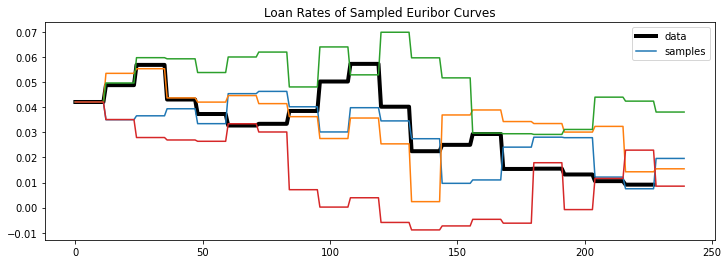

In [19]:
sampled_rates = get_loan_rates(
    samples,
    renew_every=12, spread=0.01)
historical_rates = get_loan_rates(
    historical_euribor.rate.values/100,
    renew_every=12, spread=0.01)

fig = plt.figure(figsize=(12,4))
plt.plot(
    historical_rates,
    color='black', lw=4, label='data')
for i in range(samples.shape[1]):
    plt.plot(
        sampled_rates[:,i],
        label='samples' if i == 0 else None)
plt.legend()
plt.title(f"Loan Rates of Sampled Euribor Curves")

In [15]:
initial_principal = 231500.00

def plot_repayments(
    loan: AmortizingLoan,
    color=None,
    ax=None
    ):
    if ax is None:
        ax = plt.gca()
    ax.plot(
        np.cumsum(loan.interests_paid),
        label='cumulative interest paid',
        color=color)
    ax.plot(
        np.cumsum(loan.principal_reductions),
        label='cumulative principal paid',
        color=color, ls="--")
    ax.axhline(loan.initial_principal, ls=":", color='black')
    ax.set_xlabel("Month")
    ax.set_ylabel("Cumulative Payment (euros)")
    ax.grid(":")
    ax.legend()
    return ax


Lets see the expenditure for the fixed interest rate banks.

Text(0.5, 0.98, 'Repayment Curves for Fixed Interest Rate Loans')

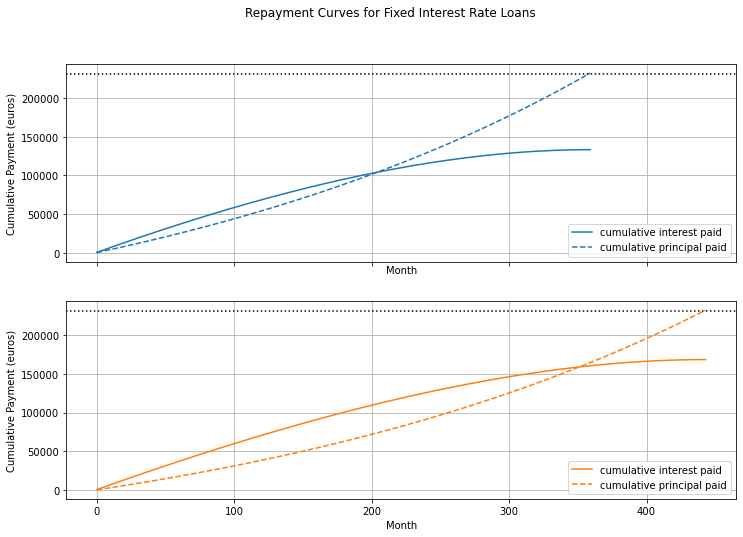

In [8]:
loan_CGD_30anos = AmortizingLoan(
    initial_principal=initial_principal)
fixed_payment_CGD_30anos = 1014.96
fixed_interest_rate_CGD_30anos = 0.033
total_payments_CGD_30anos = 360
for i in range(total_payments_CGD_30anos):
    loan_CGD_30anos.payment_update(
        payment=fixed_payment_CGD_30anos,
        interest_rate_annual=fixed_interest_rate_CGD_30anos)

loan_NB_37anos = AmortizingLoan(
    initial_principal=initial_principal)
fixed_payment_NB_37anos = 902.66
fixed_interest_rate_NB_37anos = 0.03286
total_payments_NB_37anos = 444
for i in range(total_payments_NB_37anos):
    loan_NB_37anos.payment_update(
        payment=fixed_payment_NB_37anos,
        interest_rate_annual=fixed_interest_rate_NB_37anos)

fig, axes = plt.subplots(2,1,figsize=(12,8), sharex=True, sharey=True)
plot_repayments(loan_CGD_30anos, ax=axes[0], color='C0')
plot_repayments(loan_NB_37anos, ax=axes[1], color='C1')
axes[0].grid(":")
axes[1].grid(":")
fig.suptitle("Repayment Curves for Fixed Interest Rate Loans")

In [9]:
# loan_CGD_30anos.get_data()zzzz

Okay, but now what might happen with variable interest rates?

First let's imagine what would happen if the rates were fixed.

Text(0.5, 0.98, 'Expected Repayment Curves for Variable Interest Rate Loans')

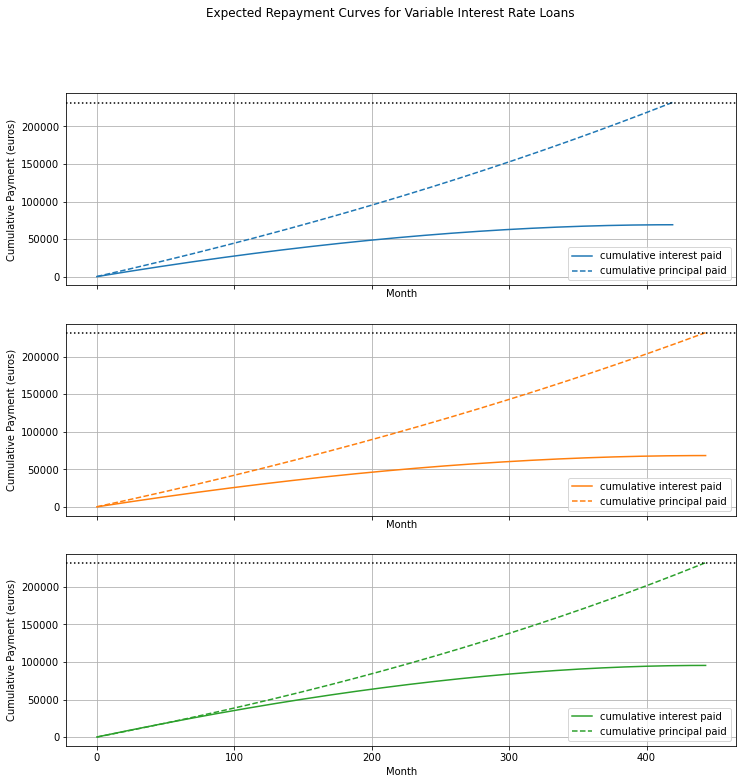

In [12]:
loan_CGD_35anos_variable = AmortizingLoan(
    initial_principal=initial_principal)
estimated_interest_rate = 0.01566
estimated_payment = 717.10
total_payments_35anos = 420
for i in range(total_payments_35anos):
    loan_CGD_35anos_variable.payment_update(
        payment=estimated_payment,
        interest_rate_annual=estimated_interest_rate)

loan_NB_37anos_variable = AmortizingLoan(
    initial_principal=initial_principal)
estimated_interest_rate = 0.01466
estimated_payment = 676.57
total_payments_37anos = 444
for i in range(total_payments_37anos):
    loan_NB_37anos_variable.payment_update(
        payment=estimated_payment,
        interest_rate_annual=estimated_interest_rate)

loan_NB_37anos_variable_annual = AmortizingLoan(
    initial_principal=initial_principal)
estimated_interest_rate = 0.0199
estimated_payment = 738.14
total_payments_37anos = 444
for i in range(total_payments_37anos):
    loan_NB_37anos_variable_annual.payment_update(
        payment=estimated_payment,
        interest_rate_annual=estimated_interest_rate)


fig, axes = plt.subplots(3,1,figsize=(12,12), sharex=True, sharey=True)
plot_repayments(loan_CGD_35anos_variable, ax=axes[0], color='C0')
plot_repayments(loan_NB_37anos_variable, ax=axes[1], color='C1')
plot_repayments(loan_NB_37anos_variable_annual, ax=axes[2], color='C2')
for i in range(len(axes)):
    axes[i].grid(":")
fig.suptitle("Expected Repayment Curves for Variable Interest Rate Loans")

Amount paid per month following this formula:
737.3445785080115
Amount given by bank:
738.14


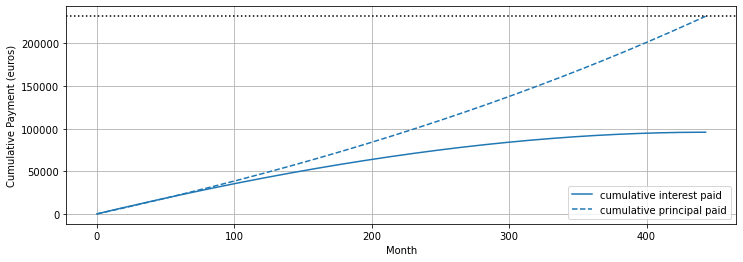

In [124]:
# test payment formula
loan_NB_37anos_variable_annual.reset()
# loan_CGD_35anos_variable.reset()
estimated_interest_rate = 0.01992
# estimated_interest_rate = 0.01566 
estimated_payment = 738.14
# estimated_payment = 717.10
total_payments = 444  # 37 years of months
# total_payments = 420
loan_NB_37anos_variable_annual.payment_update(
# loan_CGD_35anos_variable.payment_update(
    payment=estimated_payment,
    interest_rate_annual=estimated_interest_rate)
for i in range(total_payments-1):
    next_amount = loan_NB_37anos_variable_annual.get_amortized_payment_amount(
    # next_amount = loan_CGD_35anos_variable.get_amortized_payment_amount(
        interest_rate_annual=estimated_interest_rate,
        num_payments_left=total_payments-1-i)
    loan_NB_37anos_variable_annual.payment_update(
    # loan_CGD_35anos_variable.payment_update(
        payment=next_amount,
        interest_rate_annual=estimated_interest_rate)
    if i == 0:
        print("Amount paid per month following this formula:")
        print(next_amount) # close, but not exact
        print("Amount given by bank:")
        print(estimated_payment)

fig = plt.figure(figsize=(12,4))
plot_repayments(
    loan_NB_37anos_variable_annual,
    # loan_CGD_35anos_variable,
    ax=plt.gca(), color='C0')
plt.grid(":")

Asset curves are often modeled with geometric Brownian motion, but that doesn't allow negative values and - anyway - the data doesn't look that way. It looks more like the differences are Gaussian. Anyway, I'll model it using Gaussian processes for now.

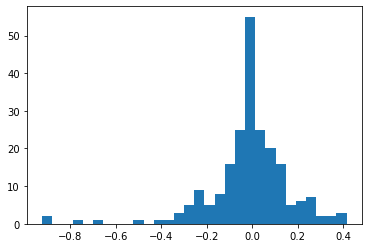

In [70]:
# this could be Gaussian
plt.hist(
    np.diff(historical_euribor.rate.values),
    bins=30);

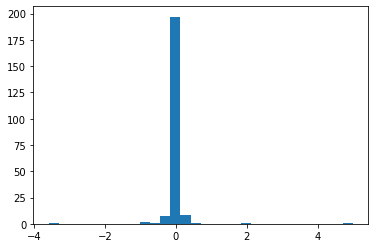

In [32]:
# this doesn't look Gaussian
plt.hist(
    np.diff(historical_euribor.rate.values)/historical_euribor.rate.values[:-1],
    bins=30);

To do this properly, we need to be able to sample variable interest rates. We don't have 40 years of data, but we can assume that the correlation stays 0 after reaching it.

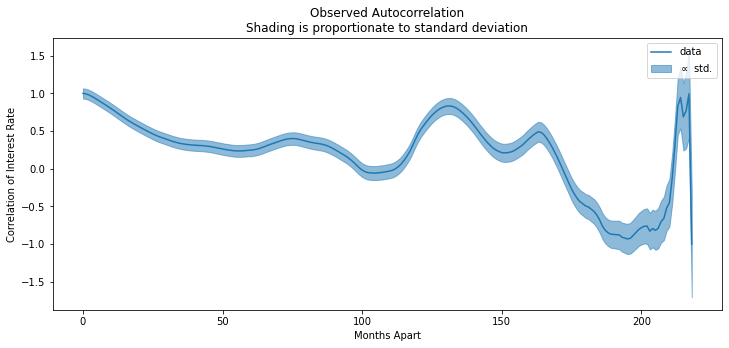

In [142]:
def get_autocorrelation(trace, max_lag=30):
    autocorrelations = np.zeros(max_lag)
    autocorrelations[0] = 1.
    for i in range(1,max_lag):
        corrcoef = np.corrcoef(trace[:-i], trace[i:])[0,1]
        autocorrelations[i] = corrcoef
    return autocorrelations


autocorrelations = get_autocorrelation(
    historical_euribor.rate.values,
    max_lag=int(historical_euribor.rate.values.shape[0]-1))
reaches_min_index = np.abs(autocorrelations).argmin()
# compute standard deviation to scale correlations
# NB: divide interest rates by 100
standard_deviation = np.std(historical_euribor.rate.values/100)


# each autocorrelation is an estimate with variance moving as 1/sqrt(n)
# where n, the number of compared values, is 
# historical_euribor.rate.values.shape[0] - i for index i
n = historical_euribor.rate.values.shape[0] \
    - np.arange(historical_euribor.rate.values.shape[0])
weights = np.sqrt(n)
# so we inversely weight the function to fit where there is more data


# def get_assumed_autocorrelations(autocorrelations, min_index, num_values):
#     assumed_autocorrelations = np.zeros(num_values)
#     assumed_autocorrelations[:min_index] = autocorrelations[:min_index]
#     return assumed_autocorrelations

plt.figure(figsize=(12,5))
plt.plot(autocorrelations, label="data")
plt.fill_between(
    np.arange(autocorrelations.shape[0]),
    autocorrelations + 1/weights[:autocorrelations.shape[0]],
    autocorrelations - 1/weights[:autocorrelations.shape[0]],
    alpha=0.5, color="C0", label="$\propto$ std.")
# plt.plot(get_assumed_autocorrelations(
#     autocorrelations, min_index=reaches_min_index, num_values=200),
#     ls="--", label="inferred")
plt.legend()
plt.xlabel("Months Apart")
plt.ylabel("Correlation of Interest Rate")
plt.title(
    "Observed Autocorrelation\n"
    +"Shading is proportionate to standard deviation")

autocorrelations = autocorrelations[:historical_euribor.rate.values.shape[0]//2]
weights = weights[:historical_euribor.rate.values.shape[0]//2]

In [143]:
from scipy.optimize import fmin

def func_to_min_laplace(tau):
    x = np.arange(autocorrelations.shape[0])
    y = np.exp(-x * tau)
    return weights @ (autocorrelations - y)**2

def func_to_min_gaussian(tau):
    x = np.arange(autocorrelations.shape[0])
    y = np.exp(-(x **2) * tau)
    return weights @ (autocorrelations - y)**2

res_laplace = fmin(func=func_to_min_laplace, x0=0.01)
res_gaussian = fmin(func=func_to_min_gaussian, x0=0.01)

Optimization terminated successfully.
         Current function value: 16.690099
         Iterations: 12
         Function evaluations: 24
Optimization terminated successfully.
         Current function value: 51.946746
         Iterations: 18
         Function evaluations: 36


Text(0.5, 1.0, 'Comparison of ')

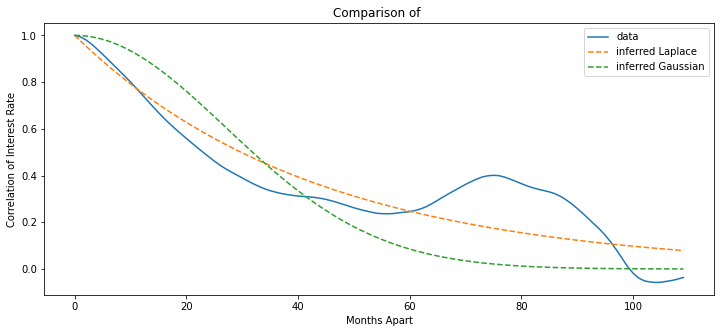

In [144]:
plt.figure(figsize=(12,5))
plt.plot(autocorrelations, label="data")
time_differences = np.arange(autocorrelations.shape[0])
assumed_autocorrelations_laplace = np.exp(-time_differences*res_laplace[0])
assumed_autocorrelations_gaussian = np.exp(-(time_differences**2) * res_gaussian[0])
plt.plot(assumed_autocorrelations_laplace,
    ls="--", label="inferred Laplace")
plt.plot(assumed_autocorrelations_gaussian,
    ls="--", label="inferred Gaussian")
plt.legend()
plt.xlabel("Months Apart")
plt.ylabel("Correlation of Interest Rate")
plt.title("Comparison of ")

In [145]:
# let's extend these further into the future:
time_differences = np.arange(40*12)
assumed_autocorrelations_laplace = np.exp(-time_differences*res_laplace[0])
assumed_autocorrelations_gaussian = np.exp(-(time_differences**2) * res_gaussian[0])

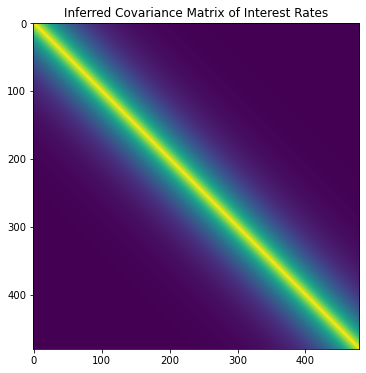

In [298]:
assumed_autocorrelations = assumed_autocorrelations_laplace
# assumed_autocorrelations = assumed_autocorrelations_gaussian

def kernel(i,j,autocorrelations,standard_deviation=1):
    return autocorrelations[np.abs(i-j).astype(int)]*standard_deviation**2

# kernel(10,40,autocorrelations=autocorrelations)
SIGMA = np.zeros((
    assumed_autocorrelations.shape[0],
    assumed_autocorrelations.shape[0]))
for i in range(SIGMA.shape[0]):
    for j in range(SIGMA.shape[0]):
        SIGMA[i,j] = kernel(
            i,j,
            autocorrelations=assumed_autocorrelations,
            standard_deviation=standard_deviation)

fig = plt.figure(figsize=(6,6))
plt.title("Inferred Covariance Matrix of Interest Rates")
plt.imshow(SIGMA)

In [299]:
# from here: https://www.euribor-rates.eu/en/
# current_euribor_12m = 0.01398
# current_euribor_6m = 0.00926

# from gaby docs
current_euribor_12m = 0.00992
current_euribor_6m = 0.00466

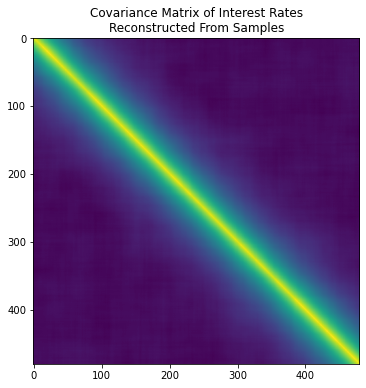

In [300]:
# now we sample a trace
X = np.random.randn(assumed_autocorrelations.shape[0], 10000)
try:
    L = np.linalg.cholesky(SIGMA)
except np.linalg.LinAlgError:
    LAM, EIGS = np.linalg.eigh(SIGMA)
    LAM[LAM < 1e-12] = 1e-12
    L = np.linalg.cholesky(EIGS @ np.diag(LAM) @ EIGS.T)

# let's imagine we start with the reported interest rate
sampled_euribors = L @ X

fig = plt.figure(figsize=(6,6))
plt.title(
    "Covariance Matrix of Interest Rates"\
    +"\nReconstructed From Samples")
plt.imshow(np.cov(sampled_euribors))

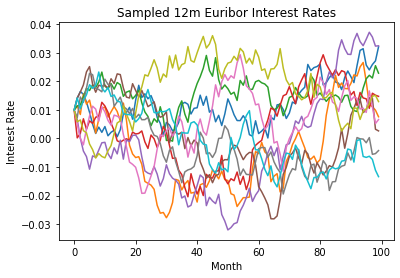

In [301]:
for j in range(10):
    plt.plot(
        sampled_euribors[:100,j]
        + current_euribor_12m - sampled_euribors[0,j])
plt.title("Sampled 12m Euribor Interest Rates")
plt.xlabel("Month")
plt.ylabel("Interest Rate")
plt.show()
# caveat: these often go negative, which may be unrealistic

Now, let's assume we have the Novo Banco spread of 1%, and a 40 year repayment schedule.  
Interest rates can only be recalculated every 12 months.

Let's also assume that if the euribor goes negative, the bank treats it as zero - they're not going to pay you, after all!

Let's see what happens.

<AxesSubplot:xlabel='Month', ylabel='Cumulative Payment (euros)'>

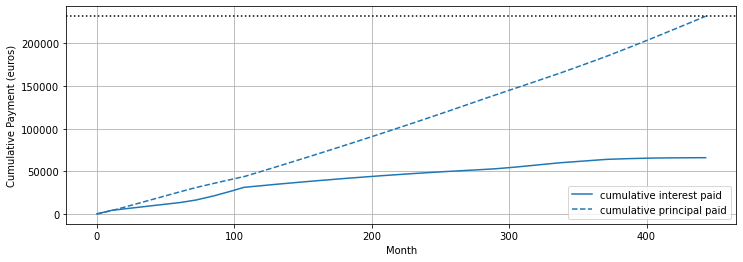

In [302]:
random_curve_idx = 12


def run_simulation(
    num_years,
    spread,
    sampled_euribor_curve,
    fixed=False
):
    num_payments = num_years * 12

    if isinstance(sampled_euribor_curve, float):
        sampled_euribor_curve = np.full(num_payments, sampled_euribor_curve)
    simulated_loan = AmortizingLoan(initial_principal=initial_principal)
    realised_ir_curve = np.array(sampled_euribor_curve)
    if not fixed:
        # reset to current value:
        realised_ir_curve += current_euribor_12m - sampled_euribor_curve[0]
    # if below zero, set to zero
    realised_ir_curve[realised_ir_curve < 0.] = 0.
    # effective_ir_curve = np.max([
    #     realised_ir_curve,
    #     np.zeros_like(realised_ir_curve)
    #     ], axis=0)

    interest_rates = realised_ir_curve + spread

    # test with fixed curve:
    # interest_rates = np.full_like(interest_rates, 0.03286)

    payments_made = 0
    for year_idx in range(num_years):
        interest_rate_this_year = interest_rates[year_idx*12]
        for month_idx in range(12):
            payment = simulated_loan.get_amortized_payment_amount(
                interest_rate_annual=interest_rate_this_year,
                num_payments_left=num_payments-payments_made)
            simulated_loan.payment_update(
                payment=payment,
                interest_rate_annual=interest_rate_this_year)
            payments_made += 1
    return simulated_loan

simulated_loan = run_simulation(
    num_years = 37,
    spread = 0.01,
    sampled_euribor_curve=sampled_euribors[:,random_curve_idx]
    # sampled_euribor_curve=np.ones(37*12)*0.02286
    )

fig = plt.figure(figsize=(12,4))
plot_repayments(
    simulated_loan,
    ax=plt.gca(), color='C0')

In [228]:
from tqdm import tqdm

def sample_euribor(
    assumed_autocorrelations,
    L_cholesky=None
    ):
    # populate covarianve matrix
    if L_cholesky is None:
        SIGMA = np.zeros((
            assumed_autocorrelations.shape[0],
            assumed_autocorrelations.shape[0]))
        for i in range(SIGMA.shape[0]):
            for j in range(SIGMA.shape[0]):
                SIGMA[i,j] = kernel(
                    i,j,
                    autocorrelations=assumed_autocorrelations,
                    standard_deviation=standard_deviation)
        try:
            L_cholesky = np.linalg.cholesky(SIGMA)
        except np.linalg.LinAlgError:
            LAM, EIGS = np.linalg.eigh(SIGMA)
            LAM[LAM < 1e-12] = 1e-12
            L_cholesky = np.linalg.cholesky(EIGS @ np.diag(LAM) @ EIGS.T)
    X = np.random.randn(L_cholesky.shape[0], 1)
    sampled_euribor = L_cholesky @ X
    sampled_euribor += current_euribor_12m - sampled_euribor[0]
    return sampled_euribor, L_cholesky

In [344]:
np.shape(None)

()

In [303]:
# let's run `num_sims`-many simulations with the Gaussian autocorrelations
num_sims = 20000
L_cholesky = None
simulated_loans_gaussian = []
for i in tqdm(range(num_sims)):
    sampled_euribor, L_cholesky = sample_euribor(
        assumed_autocorrelations=assumed_autocorrelations_gaussian,
        L_cholesky=L_cholesky)
    simulated_loan = run_simulation(
        num_years = 40,
        spread = 0.01,
        sampled_euribor_curve=sampled_euribor)
    simulated_loans_gaussian.append(simulated_loan)


100%|██████████| 20000/20000 [05:01<00:00, 66.39it/s] 


In [304]:
# and with the Laplace autocorrelations
L_cholesky = None
simulated_loans_laplace = []
for i in tqdm(range(num_sims)):
    sampled_euribor, L_cholesky = sample_euribor(
        assumed_autocorrelations=assumed_autocorrelations_laplace,
        L_cholesky=L_cholesky)
    simulated_loan = run_simulation(
        num_years = 40,
        spread = 0.01,
        sampled_euribor_curve=sampled_euribor)
    simulated_loans_laplace.append(simulated_loan)


100%|██████████| 20000/20000 [04:41<00:00, 71.12it/s]


Let's look at the maximum monthly expenditure for each simulation:

In [327]:
percentages = np.arange(0,100,0.5)

In [322]:
def get_payments_array(loan):
    return np.array(loan.interests_paid) + np.array(loan.principal_reductions)

max_payment_samples_gaussian = list(map(np.max, map(
    get_payments_array, simulated_loans_gaussian)))
max_payment_samples_laplace = list(map(np.max, map(
    get_payments_array, simulated_loans_laplace)))
    

percentiles_gaussian = np.percentile(max_payment_samples_gaussian, percentages)
percentiles_laplace = np.percentile(max_payment_samples_laplace, percentages)

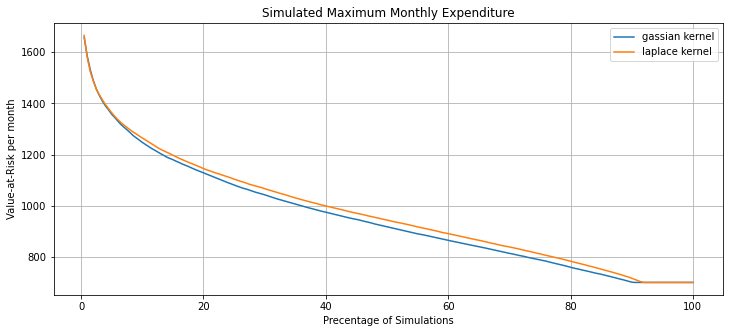

In [323]:
plt.figure(figsize=(12,5))
plt.plot(
    100-percentages,
    percentiles_gaussian,
    label="gassian kernel")
plt.plot(
    100-percentages,
    percentiles_laplace,
    label="laplace kernel")
plt.legend()
plt.xlabel("Precentage of Simulations")
plt.ylabel("Value-at-Risk per month")
plt.title("Simulated Maximum Monthly Expenditure")
plt.grid(":")
plt.show()

Maybe more intuitive is the total amount that is paid:

In [324]:
def get_total_payment(loan):
    return get_payments_array(loan).sum()

total_payment_samples_gaussian = list(map(
    get_total_payment, simulated_loans_gaussian))
total_payment_samples_laplace = list(map(
    get_total_payment, simulated_loans_laplace))

percentiles_gaussian = np.percentile(total_payment_samples_gaussian, percentages)
percentiles_laplace = np.percentile(total_payment_samples_laplace, percentages)

In [325]:
# get baselines
fixed_loan = run_simulation(
    num_years=37,
    spread=0.01,
    sampled_euribor_curve=0.02286,
    fixed=True
)
total_NB_37ano = get_total_payment(fixed_loan)

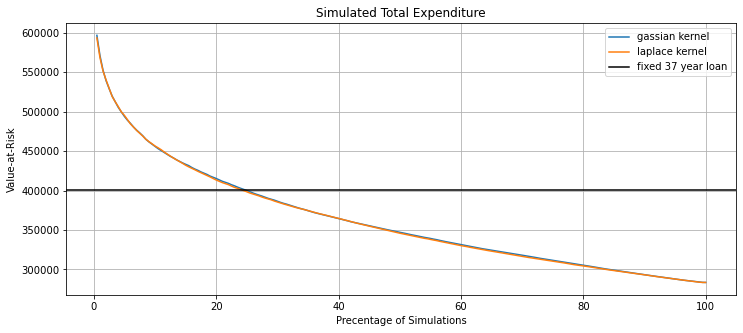

In [326]:
plt.figure(figsize=(12,5))
plt.plot(
    100-percentages,
    percentiles_gaussian,
    label="gassian kernel")
plt.plot(
    100-percentages,
    percentiles_laplace,
    label="laplace kernel")
plt.axhline(
    total_NB_37ano,
    color='black',
    label='fixed 37 year loan')
plt.legend()
plt.xlabel("Precentage of Simulations")
plt.ylabel("Value-at-Risk")
plt.title("Simulated Total Expenditure")
plt.grid(":")
plt.show()

Why did changing the number of simulations from $5000$ to $20000$ change these curves so much?